# **Box-Plots for Education**

Budgets for schools are huge and complex, making it hard to understand how resources are used. Education Resource Strategies(http://www.erstrategies.org/) is a non profit that tackles school budgets with the goal of letting districts be smatter and more effective in their spending. Founded in 2004, Education Resource Strategies has spent over 10 years finding better ways to allocate resources in order to maximize student acheivment.
    
In the code below, we will be exploring budget data across school districts by looking at how and where resources are being spent. After that, a model will be built to predict the probability that a certain label is attached to a budget line item. The data for this study can be access at http://drivendata.org.

## Downloading Data
  
First, we need to import the  school budget datset.
    
* School_budget: Includes 25 columns, with 16 of those columns being feature columns and 9 being label columns. Since we are just exploring the data in this post, we will not have any features or labels but will use the data as one big dataset. Information for each column can be found at https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/page/86/

In [1]:
#import packages
from pathlib import Path
    
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
import matplotlib.ticker as tick
import re
   
%matplotlib inline
sns.set()

In [2]:
school_budget = pd.read_csv('~/Downloads/Education_Training_set.csv')

In [3]:
print("school_budget shape:", school_budget.shape)

school_budget shape: (400277, 26)


In [4]:
school_budget.head()

,Unnamed: 0,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
0,134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
1,206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
2,326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
3,364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
4,47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


## Data Exploration
    
### Top Counts
Bellow we are going to look at the total counts of different variables such as what funds are used for(`Object_Description`), which departments these expeditures are tied to(`Facility_or_Department`), and what function these funds are serving(`Function`). Please note that just because a particular variable has the most amount of counts doesn't mean that is where most of the money is being spent.
    
#### What Funds are Used For
 
Let's look at the top categories of what funds are used for with and without `Nan` values.

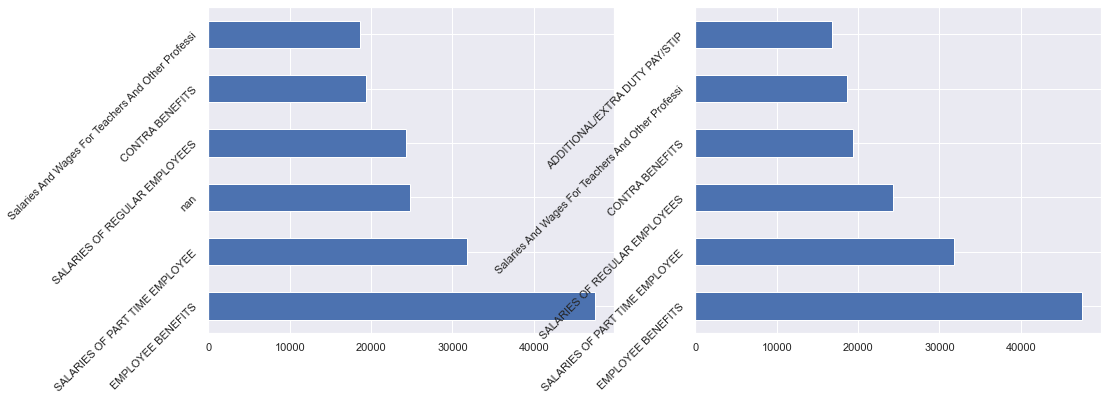

In [5]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
object_description=(school_budget['Object_Description'].value_counts(dropna=True).sort_values(ascending=False))
object_description[0:6].plot.barh(ax=ax[1],rot=45)

object_description_nan=(school_budget['Object_Description'].value_counts(dropna=False).sort_values(ascending=False))
object_description_nan[0:6].plot.barh(ax=ax[0],rot=45)

#### Departments
    
Let's look at what departments within the school expenditures are being tied to, with and without `Nan` values.

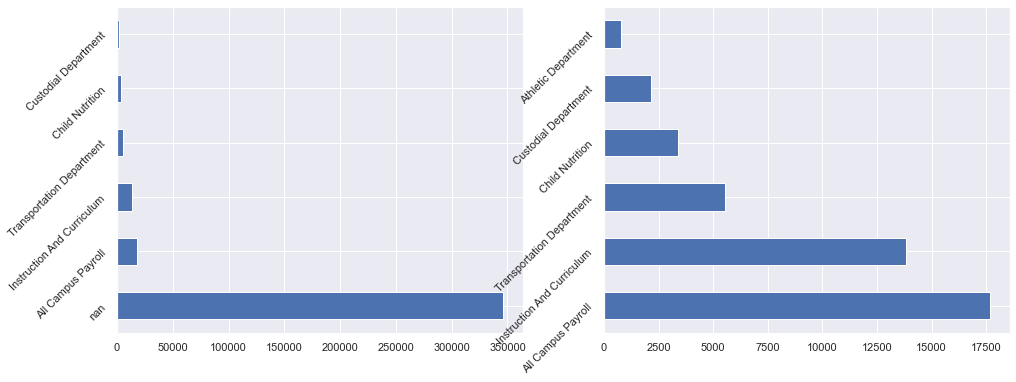

In [6]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
Facility=(school_budget['Facility_or_Department'].value_counts(dropna=True).sort_values(ascending=False))
Facility[0:6].plot.barh(ax=ax[1],rot=45)

Facility_nan=(school_budget['Facility_or_Department'].value_counts(dropna=False).sort_values(ascending=False))
Facility_nan[0:6].plot.barh(ax=ax[0],rot=45)

#### Function of Funds
    
Let's look at what function the funds are serving with and without the `NO_LABEL` variable.

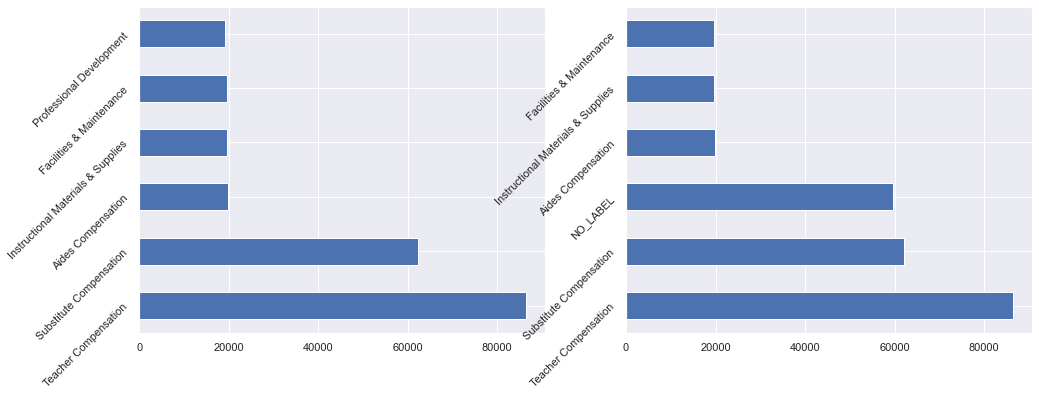

In [10]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
function=(school_budget['Function'].value_counts(dropna=True).sort_values(ascending=False))
function[0:6].plot.barh(ax=ax[1],rot=45)

function_nan=(school_budget['Function'].value_counts(dropna=False).drop('NO_LABEL').sort_values(ascending=False))
function_nan[0:6].plot.barh(ax=ax[0],rot=45)

### Where is the money going?
 Let's take a look at how much money is being spent in different fuctional areas of the schools. 

In [11]:
#Function to turn schientific notation into dollar amounts
    
def reformat_large_tick_values(tick_val, pos):
        
    #Turns large tick values (in the billions, millions and thousands)
    #such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal)
    
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val
    
    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
        
    # code below will keep 4.5M as is but change values such as 
    #4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
                
    return new_tick_format

Below are the top ten fuctions the budget is being spent on.

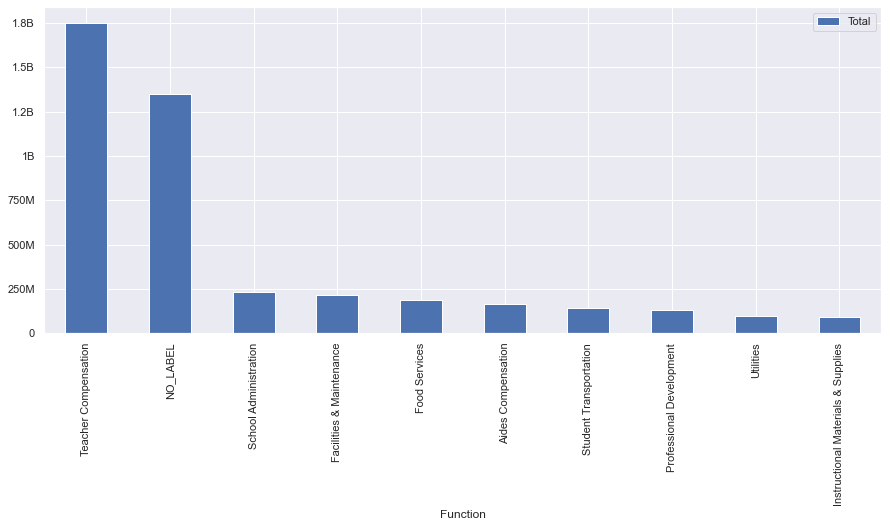

In [13]:
#top 10 fuctions the budget is being spent on
total_cost=school_budget[['Function','Total']]
all_cost=total_cost.groupby(['Function']).sum('Total').sort_values(by='Total',ascending=False)
all_cost[:10].plot.bar(figsize=(15,6))
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

As we can see, a large portion of the budget is spent on items such as teacher compensation , school administration, and student transportation. We can take a look below to notice other expenditures the buget is going towards.

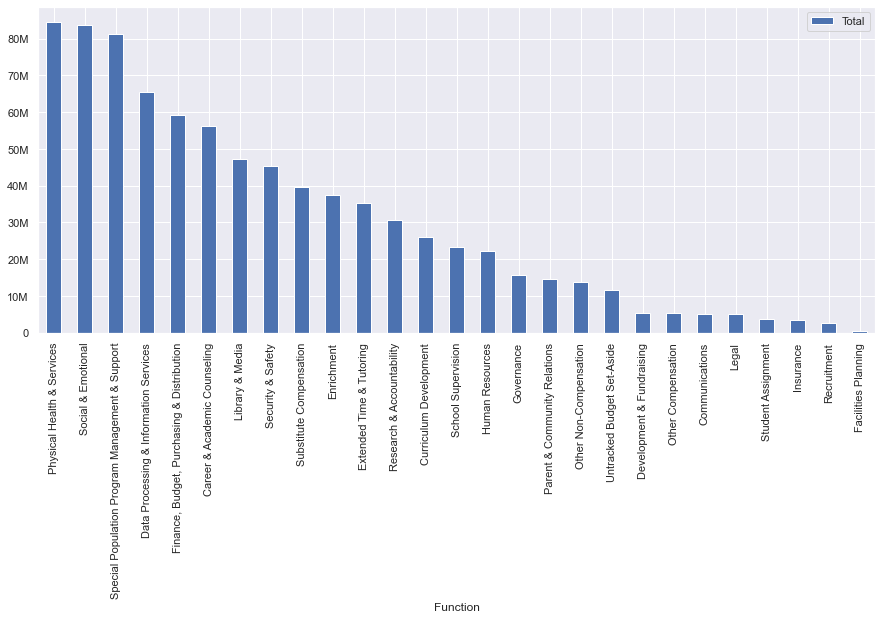

In [14]:
all_cost[10:].plot.bar(figsize=(15,6))
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

### Text Exploration
    
Let's take a deeper look at the data by analyzing further details on what programs are being used for. We are going to take columns(`Program_Description`,`SubFund_Description`,`Sub_Object_Description`,`Text_1`,`Text_2`,`Text_3`,`Text_4`) that have additional text regarding what the funds were used for, join them together, and see if we can find any further information about the school budget.

In [15]:
#combine columns together
text_data=school_budget[['Program_Description','SubFund_Description',
                        'Sub_Object_Description','Text_1','Text_2','Text_3','Text_4']]
text_data=text_data.astype(str)
text_data["combined"] = [' '.join(row) for row in text_data[text_data.columns].values]
text_data=text_data['combined'].str.lower()

In [16]:
text_data

0                      kindergarten nan nan nan nan nan nan
1         building improvement services building fund na...
2         instruction - regular nan nan nan nan nan regu...
3         general middle/junior high sch general fund na...
4         general high school education general fund nan...
                                ...                        
400272    nan nan nan staff dev and instr media      nan...
400273    instructional staff training federal gdpg fund...
400274                         misc nan nan nan nan nan nan
400275    media support services levy override nan instr...
400276    accelerated education "title  part a improving...
Name: combined, Length: 400277, dtype: object

Everything looks a little messy with `nan` values, punctuation such as `-` and `/`, and empty spaces. Lets clean the data by removing all `nan` values, punctuation, and empty space.

In [17]:
text_data.replace(r'nan', " ",regex=True,inplace=True) #removes nan values
text_data.replace(r'[^\w\s]', " ",regex=True,inplace=True) #removes puctuation except '_'
text_data.replace(r'[_]', " ",regex=True,inplace=True) #removes '_'
text_data.replace(r' +', " ",regex=True,inplace=True) #removes empty space

In [18]:
text_data

0                                             kindergarten 
1         building improvement services building fund bu...
2                   instruction regular regular instruction
3         general middle junior high sch general fund re...
4         general high school education general fund reg...
                                ...                        
400272                           staff dev and instr media 
400273    instructional staff training federal gdpg fund...
400274                                                misc 
400275    media support services levy override instructi...
400276    accelerated education title part a improving b...
Name: combined, Length: 400277, dtype: object

That looks a bit better! Let's do some quick exploration and see if we can find any rows that mention `student services` or anything that begins with `instruct` (can be instruction, instructional, etc.

In [19]:
text_data[text_data.str.count(r'\w student services \w')>0]

205       special education s l general fund special edu...
1114      special education other tosas general fund spe...
1134      social work services general fund students stu...
2178      social work services general fund students stu...
2200      social work services general fund students stu...
                                ...                        
397103    special education general fund special educati...
397699    special education ot general fund special educ...
398650    itemgb student services arra stimulus support ...
399365    psychological services general fund students s...
399640    itemgb student services arra stimulus support ...
Name: combined, Length: 630, dtype: object

In [20]:
text_data[text_data.str.count(r'\w instruct\w+')>0]

2                   instruction regular regular instruction
3         general middle junior high sch general fund re...
4         general high school education general fund reg...
6         special education local local special educatio...
8         general elementary education general fund regu...
                                ...                        
400268              instruction regular regular instruction
400270     support services instructional staff awards a...
400271    instructional staff training federal gdpg fund...
400273    instructional staff training federal gdpg fund...
400275    media support services levy override instructi...
Name: combined, Length: 141408, dtype: object

We have a couple of hits, let's look a little deeper in the data and see which words are most commonly used.

#### Most Commonly Used Words
    
Let's take a look at the 20 most common words in the data! In order to do this we are going to use the Counter function from `collections` and stopwords from `nltk`. Stop words are commonly used words suchs as an, the, and in. Since these words don't give us a lot of information about school budgets and take up processing time, we are going to remove them from out dataset.

In [21]:
#make a list
text=text_data.to_list()

In [22]:
#join columns and count most common words
from collections import Counter
most=Counter(' '.join(text).split()).most_common(20)

In [23]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sarasandman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's take a quick peek at which words are used the most.

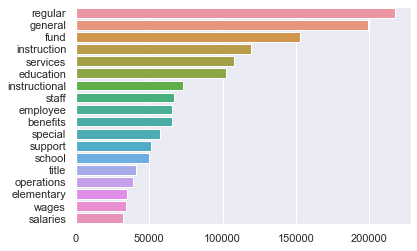

In [24]:
x, y= [], []
for word,count in most:
    if word not in stop:
        y.append(word)
        x.append(count)
            
sns.barplot(x=x,y=y)

Looks great! Just for fun lets end with a word cloud....

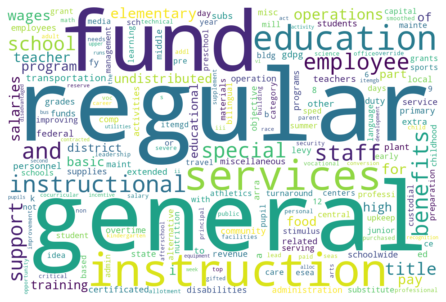

In [25]:
from wordcloud import WordCloud
    
counter=Counter(' '.join(text).split())
    
def wordcloud(counter):
    wc=WordCloud(width=1200,height=800,
                background_color='white',max_words=200)
    wc.generate_from_frequencies(counter)
    
    fig=plt.figure(figsize=(6,4))
    plt.imshow(wc,interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    
wordcloud(counter)

### Final Thoughts
   
From the information we have gathered above, it looks like a lot of the budget is going towards items such as teacher compensation, food services, and instruction. In particular, we can note that instruction was the fourth most used word in the text data and was one of the top ten highest budget items. In order to improve this analysis we could do more processing steps such as lemminization and look further into the breakdown of teacher compensation. In the next section of this analysis, we will build a model to predict the probability that a certain label is attached to a budget line item.